In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from itertools import repeat


In [2]:
# # Global Parameters

#Case 2
mu1 = 1.0e-3         # Viscosity of water (mPa.s)
mu2 = 0.1e-3         # Viscosity of hydrogen (mPa.s)
Kr1max = 0.15      # Maximum relative permeability for water
Kr2max = 1      # Maximum relative permeability for hydrogen
a = 4             # Exponent in water relative permeability function
b = 1.5           # Exponent in hydrogen relative permeability function
S1i = 0.2         # Initial water saturation
S2r = 0.5         # Residual hydrogen saturation
K = 1e-13         # Absolute permeability (m²)
phi = 0.25        # Porosity
Pc_max = 100 * 10**3      # Maximum capillary pressure (kPa)
c = 0.3           # Capillary pressure exponent
S1_star = 0.5     # Critical saturation (where Pc(S1*) = 0)
case = "Case 2"   # Example case name
phase1 = "Water"
phase2 = "H2"


# Analytical Spontaneous Imbibition

In [3]:
def Pc(S1):
    """
    Compute capillary pressure based on saturation S1.
    """
    S_div1 = (S1_star / S1i) ** (-c)
    S_div2 = (S1 / S1i) ** (-c)
    return Pc_max * ((S_div1 - S_div2) / (S_div1 - 1))

def Kr1_Kr2(S1):
    """
    Compute relative permeabilities for water and hydrogen.
    """
    Se = (S1 - S1i) / (1 - S2r - S1i)
    Kr1 = Kr1max * (Se ** a)
    Kr2 = Kr2max * ((1 - Se) ** b)
    return Kr1, Kr2

def dPc_dS1(S1, time_step=1e-4):
    """
    Compute the derivative dPc/dS1 using finite differences.
    """
    return (Pc(S1 + time_step) - Pc(S1)) / time_step

def D(S1):
    """
    Compute the diffusivity D as a function of saturation S1.
    """
    kr1, kr2 = Kr1_Kr2(S1)
    dPcdS1_val = dPc_dS1(S1)
    return -(((kr1/mu1) * (kr2/mu2)) / (kr1/mu1 + kr2/mu2)) * K * dPcdS1_val

def C2_imb(Beta):
    """
    Auxiliary function used in computing C2.
    """
    return ((Beta - S1i) * D(Beta)) / ((Beta - S1i) / (S1_star - S1i))

def F1_imb(Beta, S1):
    """
    Auxiliary function used in computing the imbibition fractional flow.
    """
    return ((Beta - S1) * D(Beta)) / ((Beta - S1i) / (S1_star - S1i))

def calculate_C2_and_F1(S1_array):
    """
    For each saturation in S1_array, iteratively compute:
      - C2 via numerical integration of C2_imb
      - F1 (imbibition fractional flow) via numerical integration of F1_imb.
    """
    C_array = []
    F1_new = []
    for i in range(len(S1_array)):
        C2 = (phi / 2) * quad(C2_imb, S1i, S1_star)[0]
        f1 = 1 - ((phi / (2 * (C2))) * quad(F1_imb, S1_array[i], S1_star, args=(S1_array[i],))[0])
        C_array.append(np.sqrt(C2))
        F1_new.append(f1)
    return C_array, F1_new


In [4]:
# Plotting Functions for Analytical Relationships

def plot_f1_vs_saturation(S1_array):
    """
    Plot the imbibition fractional flow F1 vs. saturation S1.
    """
    _, f1_values = calculate_C2_and_F1(S1_array)
    plt.figure(figsize=(8,6))
    plt.plot(S1_array, f1_values, 'b-', label='F₁(S₁)')
    plt.xlabel('Saturation of ' + phase1 + ' (-)')
    plt.ylabel('Fractional Flow F₁ (-)')
    plt.title(case + ': Fractional Flow vs. Saturation')
    plt.grid(True)
    plt.gca().set_xlim([0.2, 0.51])
    plt.gca().set_ylim([0, 1])
    plt.legend()
    plt.show()

def f_flow_deriv(S1_array):
    """
    Calculate the derivative of fractional flow with respect to S1.
    """
    C2_val = calculate_C2_and_F1(S1_array)[0][0]
    f1_values = np.array(calculate_C2_and_F1(S1_array)[1])
    f1_values_shift = np.array(calculate_C2_and_F1(S1_array + 1e-4)[1])
    f_deriv = (f1_values_shift - f1_values) / 1e-4
    return f_deriv * ((2 * C2_val) / phi)

def plot_imb(S1_array):
    """
    Plot the derivative of the fractional flow (interpreted as ω) vs. saturation.
    """
    f1_deriv = f_flow_deriv(S1_array)
    plt.figure(figsize=(8,6))
    plt.plot(f1_deriv, S1_array, 'm-', label=r'$\omega(S₁)$ (Analytical)')
    plt.xlabel(r'$\omega$')
    plt.ylabel('Saturation of ' + phase1 + ' (-)')
    plt.title(case + ': ω as a Function of Saturation')
    plt.grid(True)
    plt.gca().set_ylim([0.2, 0.51])
    plt.gca().set_xlim([0, 0.0030]) # For Case 2
    # plt.gca().set_xlim([0, 0.00025]) # For Case 3
    plt.legend()
    plt.show()

def plot_D_vs_S1(S1_array):
    """
    Plot the diffusivity D as a function of saturation S1.
    """
    D_values = [D(s) for s in S1_array]
    plt.figure(figsize=(8,6))
    plt.plot(S1_array, D_values, 'g-', label='D(S₁)')
    plt.xlabel('Saturation S₁')
    plt.ylabel('Diffusivity D')
    plt.title(case + ': Diffusivity vs. Saturation')
    plt.grid(True)
    plt.legend()
    plt.show()

def plot_relperm(mu1, mu2, Kr1max, Kr2max, a, b, S2r, S1i, case, phase1, phase2):
    # Generate S1 values from S1i to 1 - S2r
    S1_vals = np.linspace(S1i, 1 - S2r, 100)
    # Calculate effective saturation
    Se_vals = (S1_vals - S1i) / (1 - S2r - S1i)
    # Calculate relative permeabilities for each phase
    Kr1_vals = Kr1max * (Se_vals ** a)  # Relative permeability for phase1
    Kr2_vals = Kr2max * ((1 - Se_vals) ** b)  # Relative permeability for phase2
    # Setup the plot
    plt.figure(figsize=(10, 6))
    plt.plot(S1_vals, Kr1_vals, label=f'$k_r$ {phase1}', color='blue')  # Plot for phase1
    plt.plot(S1_vals, Kr2_vals, label=f'$k_r$ {phase2}', color='red')  # Plot for phase2
    # Axis labels and plot title
    plt.xlabel(f'Saturation of {phase1} ($-$)')
    plt.ylabel('Relative Permeability ($-$)')
    # Setting axis limits for better readability
    #plt.xlim(0, 1)  # Saturation should be within the range from 0 to 1
    plt.ylim(0, 1)  # Assuming Kr values should be within 0 to 1
    plt.title(f'{case}: Relative Permeability vs Saturation for {phase1} and {phase2}')
    # Add legend and grid
    plt.legend()
    plt.grid(True)
    # Show the plot
    plt.show()

def plot_Pc_vs_S1(S1_array):
    """
    Plot the capillary pressure Pc as a function of saturation S1.
    """
    Pc_values = [Pc(s) for s in S1_array]
    plt.figure(figsize=(8,6))
    plt.plot(S1_array, Pc_values, 'c-', label='Pc(S₁)')
    plt.xlabel('Saturation S₁')
    plt.ylabel('Capillary Pressure Pc (Pa)')
    plt.title(case + ': Capillary Pressure vs. Saturation')
    plt.grid(True)
    plt.legend()
    plt.show()

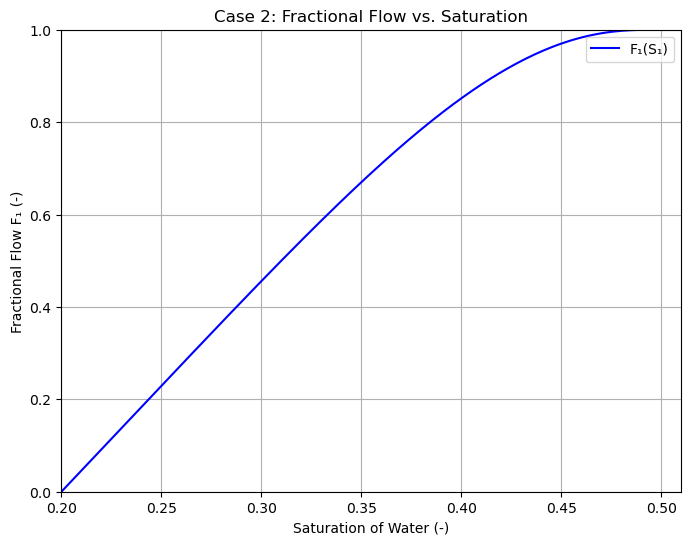

/home/peo23/downloads/cd/lib/python3.12/site-packages/scipy/integrate/_quadpack_py.py:606: ComplexWarning: Casting complex values to real discards the imaginary part
  return _quadpack._qagse(func,a,b,args,full_output,epsabs,epsrel,limit)


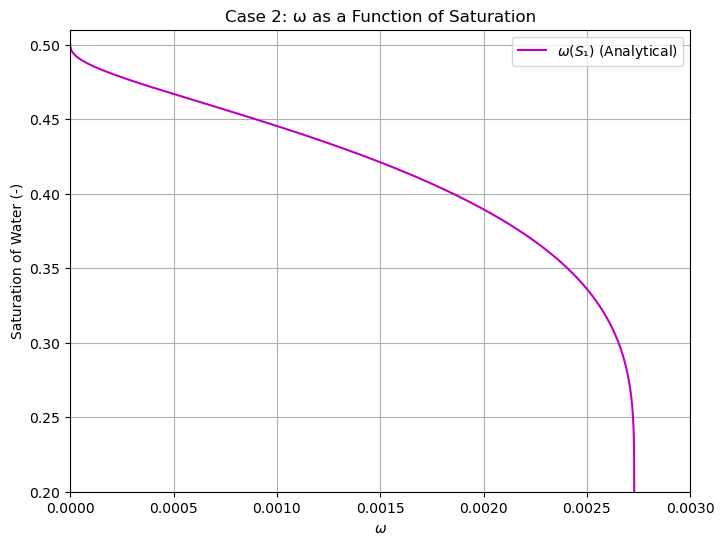

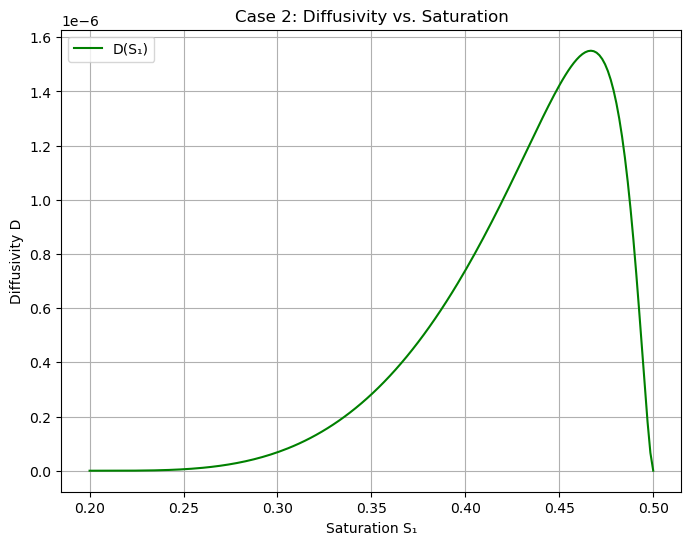

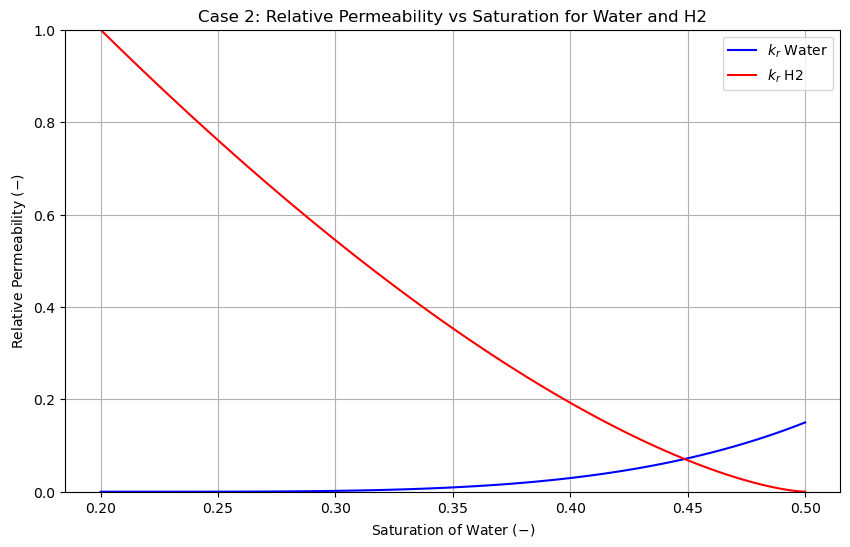

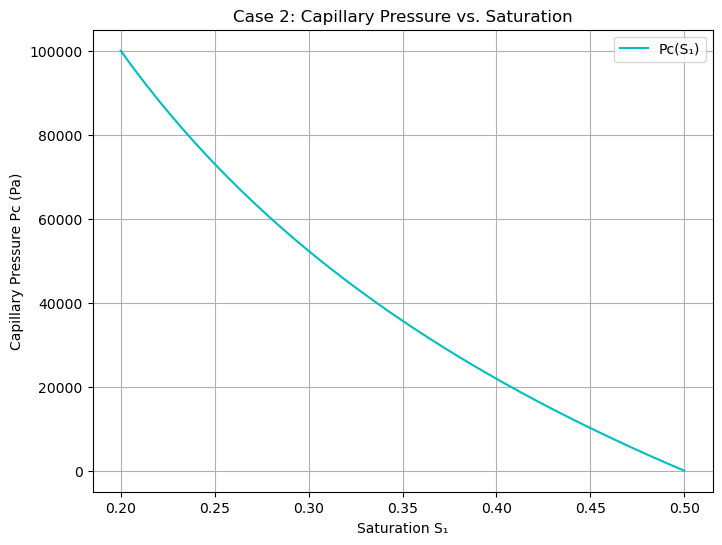

In [5]:
# Define a saturation range for analytical plots
S1_vals = np.linspace(S1i, 1 - S2r, 200)

# Plot Fractional Flow vs. Saturation (with iteration info)
plot_f1_vs_saturation(S1_vals[S1_vals<=S1_star+0.001])

# Plot the derivative of fractional flow (ω) vs. S₁ (analytical)
plot_imb(S1_vals[S1_vals<=S1_star + 0.001])

# Plot Diffusivity vs. Saturation
plot_D_vs_S1(S1_vals[S1_vals<=S1_star + 0.001])

# Plot Relative Permeability (Kr) vs. Saturation
plot_relperm(mu1, mu2, Kr1max, Kr2max, a, b, S2r, S1i, case, phase1, phase2)

# Plot Capillary Pressure (Pc) vs. Saturation
plot_Pc_vs_S1(S1_vals[S1_vals<=S1_star +0.001])

# Numerical Spontaneous Imbibition

In [6]:
def grid_sp():
    """
    Create the spatial grid for the numerical solution.
    The grid starts with S1_star and then 100 points with value S1i.
    """
    grid_list = [S1_star]
    grid_list.extend(repeat(S1i, 10000))
    grid_array = np.array(grid_list)
    dx_val = 1 / (len(grid_array) - 1)
    return grid_array, dx_val

def large_func(S1_dummy, dt, n):
    """
    Finite difference solver for the spontaneous imbibition equation.
    S1_dummy is not used; the solution uses fixed boundary conditions.
    """
    grid_array, dx_val = grid_sp()
    n_points = len(grid_array)
    S_new = np.zeros((n, n_points))
    
    for i in range(n):
        for j in range(n_points):
            if i == 0 and j > 0:
                S_new[i, j] = S1i
            elif j == 0:
                S_new[i, j] = S1_star
            elif j == (n_points - 1):
                S_new[i, j] = S1i
            else:
                if i > 0:
                    D_in = D((S_new[i-1, j-1] + S_new[i-1, j]) / 2)
                    D_out = D((S_new[i-1, j] + S_new[i-1, j+1]) / 2)
                    De_in = D_in / phi
                    De_out = D_out / phi
                    F_in = -De_in * ((S_new[i-1, j] - S_new[i-1, j-1]) / dx_val)
                    F_out = -De_out * ((S_new[i-1, j+1] - S_new[i-1, j]) / dx_val)
                    S_new[i, j] = S_new[i-1, j] + (F_in - F_out) * (dt / dx_val)
                else:
                    S_new[i, j] = S1i
    return S_new


In [7]:
# Plotting Functions for Numerical and Combined Solutions

def plot_f1_numeric(S1_dummy, dt, n):
    """
    Plot the numerical solution: S₁ vs. ω.
    S1_dummy is not used (the numerical solution uses fixed boundary conditions).
    """
    S_arr = large_func(S1_dummy, dt, n)
    S_last = S_arr[n-1, :]
    grid_array, dx_val = grid_sp()
    tD = n * dx_val  # Characteristic time scale
    x = dx_val * (np.arange(len(grid_array)) - 0.5)
    omega = x / np.sqrt(tD)
    plt.figure(figsize=(8,6))
    plt.plot(omega, S_last, 'b-', label='Numerical S₁(ω)')
    plt.xlabel(r'$\omega$ (m/$\sqrt{s}$)')
    plt.ylabel('Saturation of ' + phase1 + ' (-)')
    plt.title(case + ': Numerical S₁ vs. ω')
    plt.grid(True)
    plt.legend()
    plt.show()

def plot_analytical_numeric(S1_array, dt, n, ds=1e-4):
    """
    Plot both the analytical (from f_flow_deriv) and numerical solutions:
      - Analytical: ω (from f_flow_deriv) vs. S₁
      - Numerical: S₁ vs. ω computed from the finite difference method.
    """
    f1_deriv = f_flow_deriv(S1_array)
    S_arr = large_func(S1_array, dt, n)
    S_last = S_arr[n-1, :]
    grid_array, dx_val = grid_sp()
    tD = n * dx_val
    x = dx_val * (np.arange(len(grid_array)) - 0.5)
    omega_num = x / np.sqrt(tD)
    
    plt.figure(figsize=(8,6))
    plt.plot(f1_deriv, S1_array, 'r-', label='Analytical ω(S₁)')
    plt.plot(omega_num, S_last, 'b--', label='Numerical S₁(ω)')
    plt.xlabel(r'$\omega$ (m/$\sqrt{s}$)')
    plt.ylabel('Saturation of ' + phase1 + ' (-)')
    plt.title(case + ': S₁ vs. ω (Analytical vs. Numerical)')
    plt.gca().set_xlim([0, 0.003]) # For Case 3
    plt.legend()
    plt.grid(True)
    plt.show()

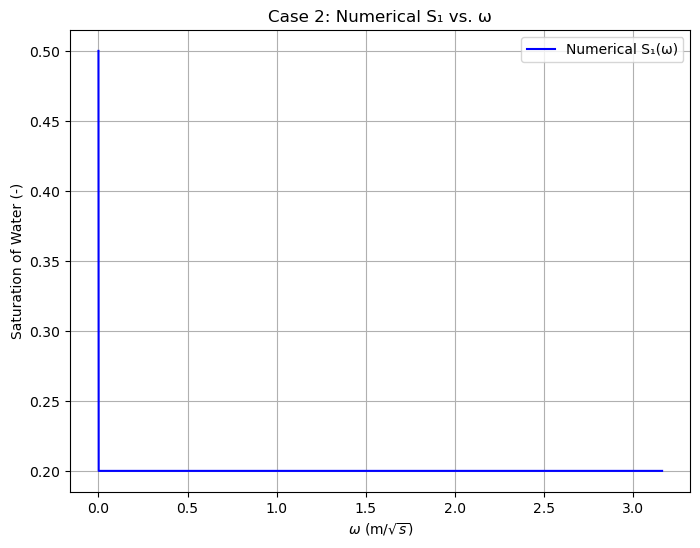

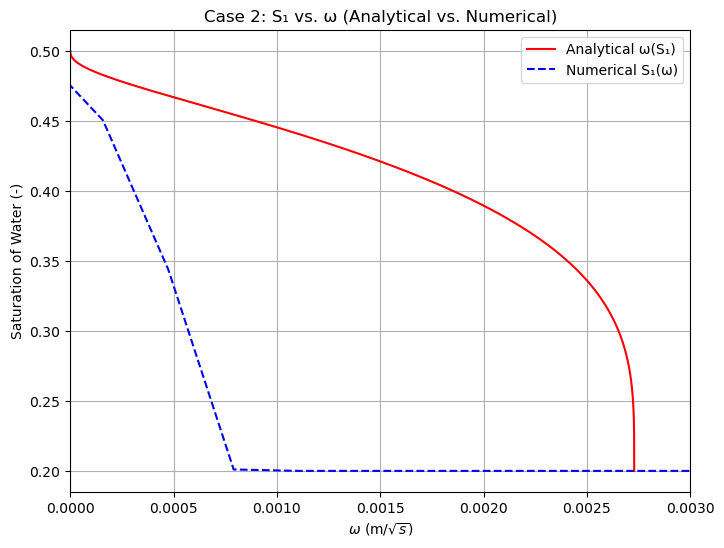

In [8]:
# Set numerical simulation parameters
dt_val = 0.00001  # time step size
n_steps = 1000   # number of time steps

# Plot the numerical solution: S₁ vs. ω
plot_f1_numeric(S1_vals, dt_val, n_steps)

# Combined plot: Analytical vs. Numerical (S₁ vs. ω)
plot_analytical_numeric(S1_vals, dt_val, n_steps)

# Case 3

In [9]:
# Case 3
mu1 = 0.4e-3         # Viscosity of water (mPa.s)
mu2 = 0.1e-3         # Viscosity of hydrogen (mPa.s)
Kr1max = 0.4      # Maximum relative permeability for water
Kr2max = 0.8      # Maximum relative permeability for hydrogen
a = 8             # Exponent in water relative permeability function
b = 3           # Exponent in hydrogen relative permeability function
S1i = 0.2         # Initial water saturation
S2r = 0.15         # Residual hydrogen saturation
K = 1e-13         # Absolute permeability (m²)
phi = 0.25        # Porosity
Pc_max = 100 * 10**3      # Maximum capillary pressure (kPa)
c = 0.3           # Capillary pressure exponent
S1_star = 0.5     # Critical saturation (where Pc(S1*) = 0)
case = "Case 3"   # Example case name
phase1 = "Water"
phase2 = "CO2"



## Analytical

In [10]:
def Pc(S1):
    """
    Compute capillary pressure based on saturation S1.
    """
    S_div1 = (S1_star / S1i) ** (-c)
    S_div2 = (S1 / S1i) ** (-c)
    return Pc_max * ((S_div1 - S_div2) / (S_div1 - 1))

def Kr1_Kr2(S1):
    """
    Compute relative permeabilities for water and hydrogen.
    """
    Se = (S1 - S1i) / (1 - S2r - S1i)
    Kr1 = Kr1max * (Se ** a)
    Kr2 = Kr2max * ((1 - Se) ** b)
    return Kr1, Kr2

def dPc_dS1(S1, time_step=1e-4):
    """
    Compute the derivative dPc/dS1 using finite differences.
    """
    return (Pc(S1 + time_step) - Pc(S1)) / time_step

def D(S1):
    """
    Compute the diffusivity D as a function of saturation S1.
    """
    kr1, kr2 = Kr1_Kr2(S1)
    dPcdS1_val = dPc_dS1(S1)
    return -(((kr1/mu1) * (kr2/mu2)) / (kr1/mu1 + kr2/mu2)) * K * dPcdS1_val

def C2_imb(Beta):
    """
    Auxiliary function used in computing C2.
    """
    return ((Beta - S1i) * D(Beta)) / ((Beta - S1i) / (S1_star - S1i))

def F1_imb(Beta, S1):
    """
    Auxiliary function used in computing the imbibition fractional flow.
    """
    return ((Beta - S1) * D(Beta)) / ((Beta - S1i) / (S1_star - S1i))

def calculate_C2_and_F1(S1_array):
    """
    For each saturation in S1_array, iteratively compute:
      - C2 via numerical integration of C2_imb
      - F1 (imbibition fractional flow) via numerical integration of F1_imb.
    """
    C_array = []
    F1_new = []
    for i in range(len(S1_array)):
        C2 = (phi / 2) * quad(C2_imb, S1i, S1_star)[0]
        #f1 = 1 - ((phi / (2 * C2)) * quad(F1_imb, S1_array[i], S1_star, args=(S1_array[i],))[0])
        f1 = 1 - ((phi / (2 * (C2))) * quad(F1_imb, S1_array[i], S1_star, args=(S1_array[i],))[0])
        C_array.append(np.sqrt(C2))
        F1_new.append(f1)
    return C_array, F1_new


In [11]:
# Plotting Functions for Analytical Relationships

def plot_f1_vs_saturation(S1_array):
    """
    Plot the imbibition fractional flow F1 vs. saturation S1.
    """
    _, f1_values = calculate_C2_and_F1(S1_array)
    plt.figure(figsize=(8,6))
    plt.plot(S1_array, f1_values, 'b-', label='F₁(S₁)')
    plt.xlabel('Saturation of ' + phase1 + ' (-)')
    plt.ylabel('Fractional Flow F₁ (-)')
    plt.title(case + ': Fractional Flow vs. Saturation')
    plt.grid(True)
    plt.gca().set_xlim([0.2, 0.51])
    plt.gca().set_ylim([0, 1])
    plt.legend()
    plt.show()

def f_flow_deriv(S1_array):
    """
    Calculate the derivative of fractional flow with respect to S1.
    """
    C2_val = calculate_C2_and_F1(S1_array)[0][0]
    f1_values = np.array(calculate_C2_and_F1(S1_array)[1])
    f1_values_shift = np.array(calculate_C2_and_F1(S1_array + 1e-4)[1])
    f_deriv = (f1_values_shift - f1_values) / 1e-4
    return f_deriv * ((2 * C2_val) / phi)

def plot_imb(S1_array):
    """
    Plot the derivative of the fractional flow (interpreted as ω) vs. saturation.
    """
    f1_deriv = f_flow_deriv(S1_array)
    plt.figure(figsize=(8,6))
    plt.plot(f1_deriv, S1_array, 'm-', label=r'$\omega(S₁)$ (Analytical)')
    plt.xlabel(r'$\omega$')
    plt.ylabel('Saturation of ' + phase1 + ' (-)')
    plt.title(case + ': ω as a Function of Saturation')
    plt.grid(True)
    plt.gca().set_ylim([0.2, 0.51])
    plt.gca().set_xlim([0, 0.00030]) # For Case 2
    # plt.gca().set_xlim([0, 0.00025]) # For Case 3
    plt.legend()
    plt.show()

def plot_D_vs_S1(S1_array):
    """
    Plot the diffusivity D as a function of saturation S1.
    """
    D_values = [D(s) for s in S1_array]
    plt.figure(figsize=(8,6))
    plt.plot(S1_array, D_values, 'g-', label='D(S₁)')
    plt.xlabel('Saturation S₁')
    plt.ylabel('Diffusivity D')
    plt.title(case + ': Diffusivity vs. Saturation')
    plt.grid(True)
    plt.legend()
    plt.show()

def plot_relperm(mu1, mu2, Kr1max, Kr2max, a, b, S2r, S1i, case, phase1, phase2):
    # Generate S1 values from S1i to 1 - S2r
    S1_vals = np.linspace(S1i, 1 - S2r, 100)
    # Calculate effective saturation
    Se_vals = (S1_vals - S1i) / (1 - S2r - S1i)
    # Calculate relative permeabilities for each phase
    Kr1_vals = Kr1max * (Se_vals ** a)  # Relative permeability for phase1
    Kr2_vals = Kr2max * ((1 - Se_vals) ** b)  # Relative permeability for phase2
    # Setup the plot
    plt.figure(figsize=(10, 6))
    plt.plot(S1_vals, Kr1_vals, label=f'$k_r$ {phase1}', color='blue')  # Plot for phase1
    plt.plot(S1_vals, Kr2_vals, label=f'$k_r$ {phase2}', color='red')  # Plot for phase2
    # Axis labels and plot title
    plt.xlabel(f'Saturation of {phase1} ($-$)')
    plt.ylabel('Relative Permeability ($-$)')
    # Setting axis limits for better readability
    #plt.xlim(0, 1)  # Saturation should be within the range from 0 to 1
    plt.ylim(0, 1)  # Assuming Kr values should be within 0 to 1
    plt.title(f'{case}: Relative Permeability vs Saturation for {phase1} and {phase2}')
    # Add legend and grid
    plt.legend()
    plt.grid(True)
    # Show the plot
    plt.show()

def plot_Pc_vs_S1(S1_array):
    """
    Plot the capillary pressure Pc as a function of saturation S1.
    """
    Pc_values = [Pc(s) for s in S1_array]
    plt.figure(figsize=(8,6))
    plt.plot(S1_array, Pc_values, 'c-', label='Pc(S₁)')
    plt.xlabel('Saturation S₁')
    plt.ylabel('Capillary Pressure Pc (Pa)')
    plt.title(case + ': Capillary Pressure vs. Saturation')
    plt.grid(True)
    plt.legend()
    plt.show()

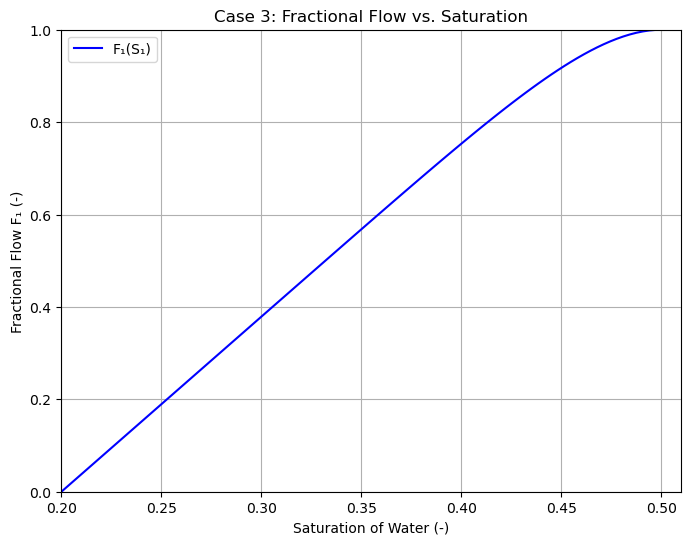

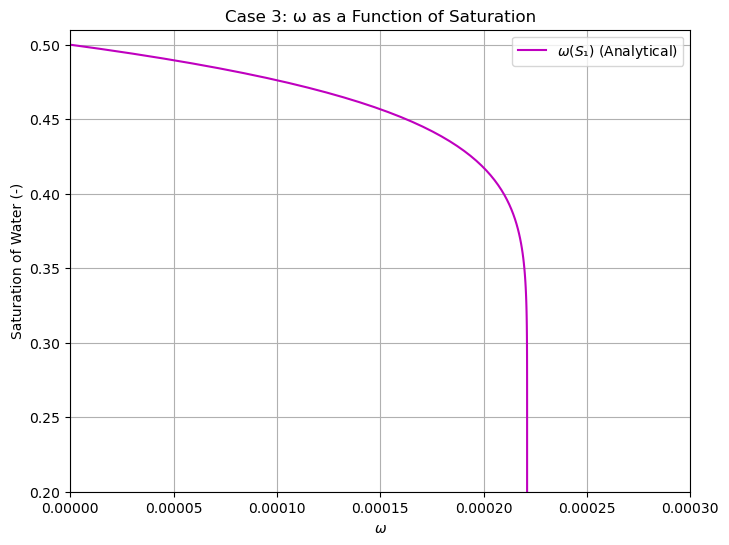

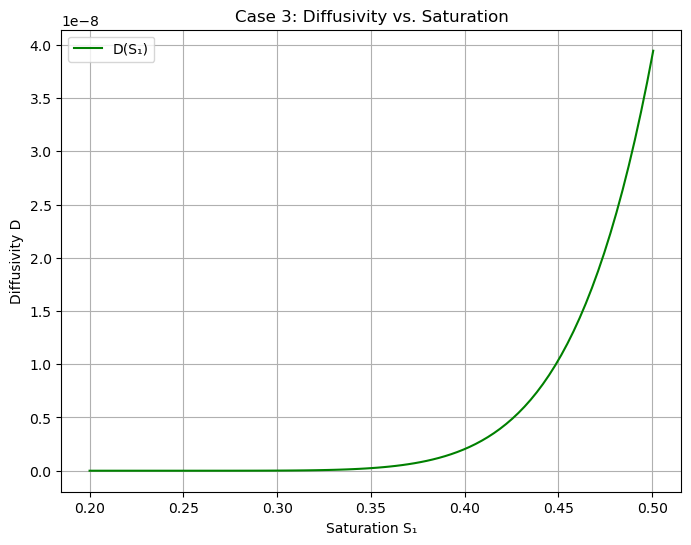

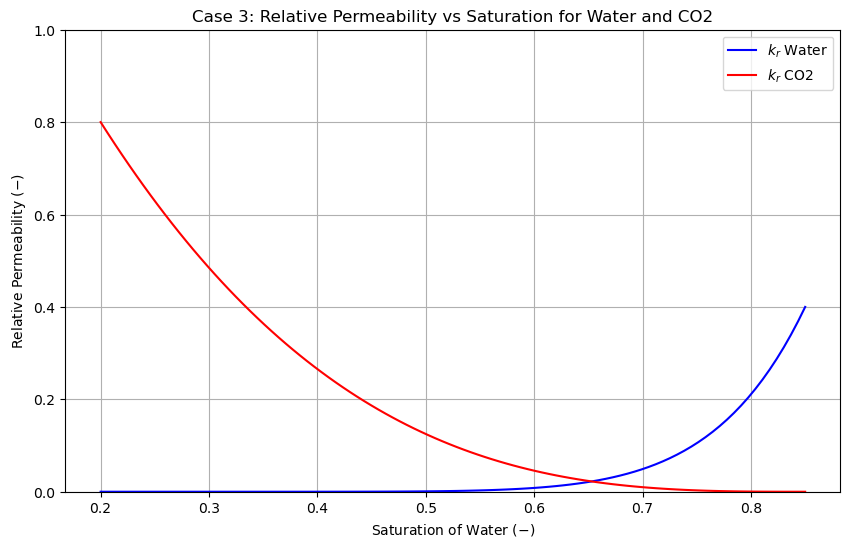

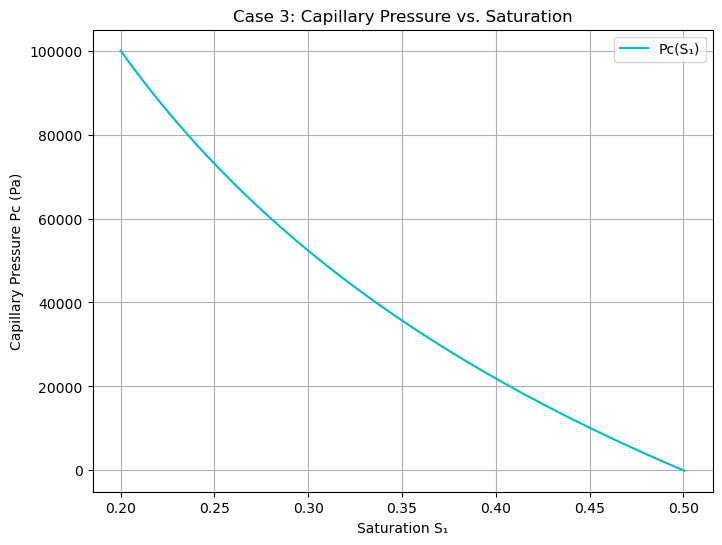

In [12]:
# Define a saturation range for analytical plots
S1_vals = np.linspace(S1i, 1 - S2r, 200)

# Plot Fractional Flow vs. Saturation (with iteration info)
plot_f1_vs_saturation(S1_vals[S1_vals<=S1_star+0.001])

# Plot the derivative of fractional flow (ω) vs. S₁ (analytical)
plot_imb(S1_vals[S1_vals<=S1_star + 0.001])

# Plot Diffusivity vs. Saturation
plot_D_vs_S1(S1_vals[S1_vals<=S1_star + 0.001])

# # Plot Relative Permeability (Kr) vs. Saturation
# plot_Kr_vs_S1(S1_vals[S1_vals<=S1_star + 0.001])

# Plot Relative Permeability (Kr) vs. Saturation
plot_relperm(mu1, mu2, Kr1max, Kr2max, a, b, S2r, S1i, case, phase1, phase2)

# Plot Capillary Pressure (Pc) vs. Saturation
plot_Pc_vs_S1(S1_vals[S1_vals<=S1_star +0.001])


## Numerical Solutions

In [13]:
def grid_sp():
    """
    Create the spatial grid for the numerical solution.
    The grid starts with S1_star and then 100 points with value S1i.
    """
    grid_list = [S1_star]
    grid_list.extend(repeat(S1i, 1000))
    grid_array = np.array(grid_list)
    dx_val = 1 / (len(grid_array) - 1)
    return grid_array, dx_val

def large_func(S1_dummy, dt, n):
    """
    Finite difference solver for the spontaneous imbibition equation.
    S1_dummy is not used; the solution uses fixed boundary conditions.
    """
    grid_array, dx_val = grid_sp()
    n_points = len(grid_array)
    S_new = np.zeros((n, n_points))
    
    for i in range(n):
        for j in range(n_points):
            if i == 0 and j > 0:
                S_new[i, j] = S1i
            elif j == 0:
                S_new[i, j] = S1_star
            elif j == (n_points - 1):
                S_new[i, j] = S1i
            else:
                if i > 0:
                    D_in = D((S_new[i-1, j-1] + S_new[i-1, j]) / 2)
                    D_out = D((S_new[i-1, j] + S_new[i-1, j+1]) / 2)
                    De_in = D_in / phi
                    De_out = D_out / phi
                    F_in = -De_in * ((S_new[i-1, j] - S_new[i-1, j-1]) / dx_val)
                    F_out = -De_out * ((S_new[i-1, j+1] - S_new[i-1, j]) / dx_val)
                    S_new[i, j] = S_new[i-1, j] + (F_in - F_out) * (dt / dx_val)
                else:
                    S_new[i, j] = S1i
    return S_new


In [14]:
# Plotting Functions for Numerical and Combined Solutions

def plot_f1_numeric(S1_dummy, dt, n):
    """
    Plot the numerical solution: S₁ vs. ω.
    S1_dummy is not used (the numerical solution uses fixed boundary conditions).
    """
    S_arr = large_func(S1_dummy, dt, n)
    S_last = S_arr[n-1, :]
    grid_array, dx_val = grid_sp()
    tD = n * dx_val  # Characteristic time scale
    x = dx_val * (np.arange(len(grid_array)) - 0.5)
    omega = x / np.sqrt(tD)
    plt.figure(figsize=(8,6))
    plt.plot(omega, S_last, 'b-', label='Numerical S₁(ω)')
    plt.xlabel(r'$\omega$ (m/$\sqrt{s}$)')
    plt.ylabel('Saturation of ' + phase1 + ' (-)')
    plt.title(case + ': Numerical S₁ vs. ω')
    plt.grid(True)
    plt.legend()
    plt.show()

def plot_analytical_numeric(S1_array, dt, n, ds=1e-4):
    """
    Plot both the analytical (from f_flow_deriv) and numerical solutions:
      - Analytical: ω (from f_flow_deriv) vs. S₁
      - Numerical: S₁ vs. ω computed from the finite difference method.
    """
    f1_deriv = f_flow_deriv(S1_array)
    S_arr = large_func(S1_array, dt, n)
    S_last = S_arr[n-1, :]
    grid_array, dx_val = grid_sp()
    tD = n * dx_val
    x = dx_val * (np.arange(len(grid_array)) - 0.5)
    omega_num = x / np.sqrt(tD)
    
    plt.figure(figsize=(8,6))
    plt.plot(f1_deriv, S1_array, 'r-', label='Analytical ω(S₁)')
    plt.plot(omega_num, S_last, 'b--', label='Numerical S₁(ω)')
    plt.xlabel(r'$\omega$ (m/$\sqrt{s}$)')
    plt.ylabel('Saturation of ' + phase1 + ' (-)')
    plt.title(case + ': S₁ vs. ω (Analytical vs. Numerical)')
    plt.gca().set_xlim([0, 0.0003])
    plt.legend()
    plt.grid(True)
    plt.show()

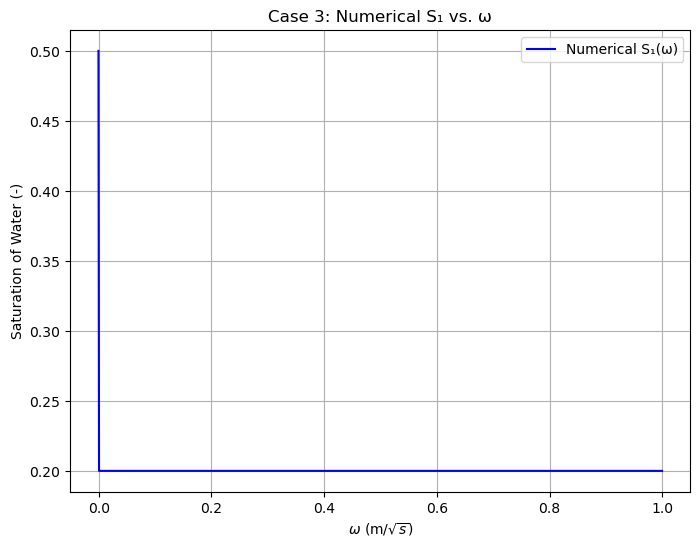

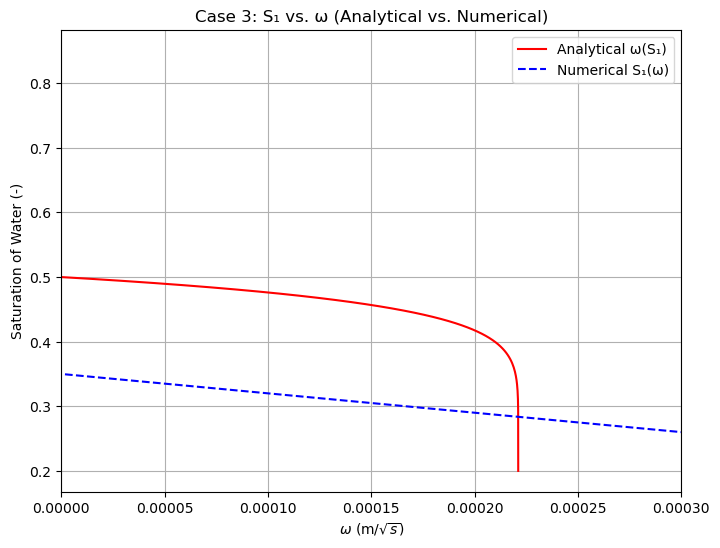

In [15]:
# Set numerical simulation parameters
dt_val = 0.00001  # time step size
n_steps = 1000   # number of time steps

# Plot the numerical solution: S₁ vs. ω
plot_f1_numeric(S1_vals, dt_val, n_steps)

# Combined plot: Analytical vs. Numerical (S₁ vs. ω)
plot_analytical_numeric(S1_vals, dt_val, n_steps)

In [16]:
import numpy as np
import matplotlib.pyplot as plt
#Case 1
mu1 = 0.1 * 10**-3
mu2 = 1 * 10**-3
Kr1max = 1
Kr2max = 1
a = 1.2
b = 3
S1i = 10e-6
S2r = 0.2
S1 = np.linspace(S1i, (1-S2r), 100)
phase1 = 'Carbon dioxide'
case = 'Case 1: '
phase2 = "Water" 

In [17]:
def plot_relperm(mu1, mu2, Kr1max, Kr2max, a, b, S2r, S1i, case, phase1, phase2):
    # Generate S1 values from S1i to 1 - S2r
    S1_vals = np.linspace(S1i, 1 - S2r, 100)
    # Calculate effective saturation
    Se_vals = (S1_vals - S1i) / (1 - S2r - S1i)
    # Calculate relative permeabilities for each phase
    Kr1_vals = Kr1max * (Se_vals ** a)  # Relative permeability for phase1
    Kr2_vals = Kr2max * ((1 - Se_vals) ** b)  # Relative permeability for phase2
    # Setup the plot
    plt.figure(figsize=(10, 6))
    plt.plot(S1_vals, Kr1_vals, label=f'$k_r$ {phase1}', color='red')  # Plot for phase2
    plt.plot(S1_vals, Kr2_vals, label=f'$k_r$ {phase2}', color='blue')  # Plot for phase1
    # Axis labels and plot title
    plt.xlabel(f'Saturation of {phase1} ($-$)')
    plt.ylabel('Relative Permeability ($-$)')
    # Setting axis limits for better readability
    #plt.xlim(0, 1)  # Saturation should be within the range from 0 to 1
    plt.ylim(0, 1)  # Assuming Kr values should be within 0 to 1
    plt.title(f'{case}: Relative Permeability vs Saturation for {phase1} and {phase2}')
    # Add legend and grid
    plt.legend()
    plt.grid(True)
    # Show the plot
    plt.show()

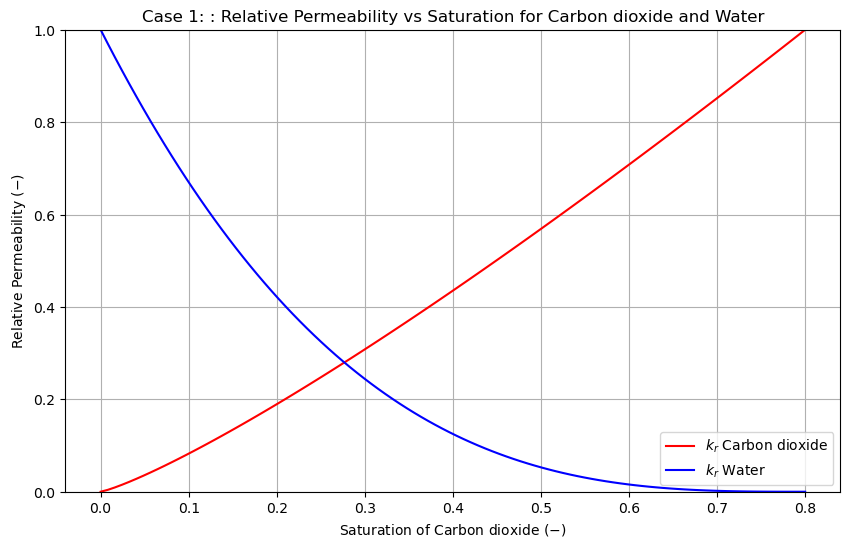

In [18]:
plot_relperm(mu1, mu2, Kr1max, Kr2max, a, b, S2r, S1i, case, phase1, phase2)